In [1]:
%matplotlib inline 
import pandas as pd 
import pylab as pl 
import numpy as np 

In [2]:
colors = {'ifc-hlm': '#d6604d',
         'a-hlm': '#92c5de',
         'd-hlm': '#225ea8'}

# Read parameters and define functions

In [3]:
param = pd.read_msgpack('data/results/hydrus_derived_param.msg')
#vols{'noT': pd.read_cs}

C:\Users\nicolas\anaconda3\envs\default\lib\site-packages\IPython\core\interactiveshell.py:3343: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
Vols={'noT': pd.read_csv('data/results/hydrus_noTile_2slope.csv', index_col=0)}
Vols.update({'yesT': pd.read_csv('data/results/hydrus_tile_2slope.csv', index_col=0)})

In [5]:
def qsLinkTile(x, m, a, c, NoFlow, B, Td, b, d):
    '''A function that recreates the approximation to tiles and no tiles 
    behavior obtained by Hydrus'''
    qout = (x - NoFlow)*m  
    if x > B:
        x1 = x - B
        qout += x1*a*np.exp(b*x1)
    if x > Td:
        x1 = x - Td
        qout += x1*c*np.exp(d*x1)
    return qout

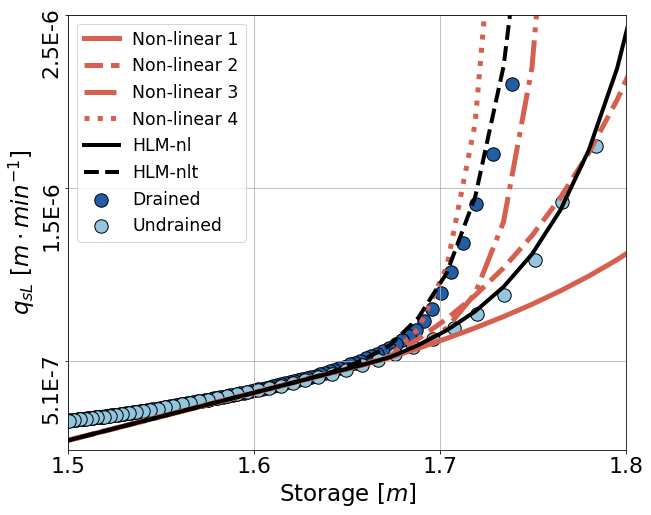

In [7]:
fig = pl.figure(figsize=(10,8))
tx = 22
ax = fig.add_subplot(111)
style = ['-','--','-.',':']

for k,la in zip(['2'],[0,1,2,3]):
    
    So = Vols['yesT']
    Ss = pd.DataFrame(np.linspace(So['vol'].min(),So['vol'].max()+0.4, 50), columns=['vol'])
    cont = 1
    for i in np.linspace(0.5, 2.5, 2):
        for j in np.linspace(0.5, 2.5, 2):
            Ss['b*'+str(i)+'_a*'+str(j)] = Ss['vol'].apply(qsLinkTile, 
                args = (param.loc[k]['m'],param.loc[k]['a']*j,
                        param.loc[k]['c']*0,
                        param.loc[k]['B'] - param.loc[k]['Sn'], 
                        param.loc[k]['B'],
                        param.loc[k]['Bd'],
                        param.loc[k]['b']*i,
                        param.loc[k]['d']))
            pl.plot(Ss['vol'], Ss['b*'+str(i)+'_a*'+str(j)],colors['ifc-hlm'], lw = 5, 
                    label = 'Non-linear '+str(cont),
                   ls = style[cont-1])
            cont+=1
    pl.scatter(So.loc[740:1250]['vol'], So.loc[740:1250]['seepage'],
               c=colors['d-hlm'], s = 180, label = 'Drained', edgecolor = 'k')
    So = Vols['noT']
    pl.scatter(So.loc[720:1250]['vol'], So.loc[720:1250]['seepage'], 
                  c=colors['a-hlm'],s = 180, label = 'Undrained', edgecolor = 'k')
    
    Ss['noT'] = Ss['vol'].apply(qsLinkTile, 
        args = (param.loc[k]['m'],param.loc[k]['a'],
                param.loc[k]['c']*0,
                param.loc[k]['B'] - param.loc[k]['Sn'], 
                param.loc[k]['B'],
                param.loc[k]['Bd'],
                param.loc[k]['b'],
                param.loc[k]['d']))
    pl.plot(Ss['vol'], Ss['noT'],'k', lw = 4, label = 'HLM-nl',
           ls = '-')
    
    Ss['yesT'] = Ss['vol'].apply(qsLinkTile, 
        args = (param.loc[k]['m'],param.loc[k]['a'],
                param.loc[k]['c'],
                param.loc[k]['B'] - param.loc[k]['Sn'], 
                param.loc[k]['B'],
                param.loc[k]['Bd'],
                param.loc[k]['b'],
                param.loc[k]['d']))
    pl.plot(Ss['vol'], Ss['yesT'],'k', lw = 4, label = 'HLM-nlt',
           ls = '--')
    
    ax.legend(loc = 0, fontsize = 'xx-large')
    ax.tick_params(labelsize = tx)
    ax.set_ylim(0, 2.5e-6)
    ax.set_xlim(1.5, 1.8)
    y = np.linspace(0.51e-6,2.5e-6,3)
    ty = ['%.1e' % i for i in y]
    ax.set_yticks(y)
    ax.set_yticklabels([i.upper().replace('0','') for i in ty], rotation = 'vertical')
    #ax.set_yticklabels([0,'5.0E-7','1.0E-6','1.5E-6','2.0E-6'])
    ax.grid()
    ax.set_xticks([1.5,1.6, 1.7,1.8])
    ax.set_xticklabels([1.5,1.6, 1.7,1.8])
    texto = ' Slope$=%s$' % k
    ax.tick_params(labelsize = tx)
    ax.set_xlabel('Storage [$m$]', size = 23)
    ax.set_ylabel('$q_{sL}$ $[m \cdot min^{-1}]$', size = 23)
pl.savefig('figures/Scenarios_seepage_curves.png', bbox_inches = 'tight')